In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:

def generate_box(line, img_shape):
    _, x, y, width, height = list(line)
    xmin = x-width/2
    ymin = y-height/2
    xmax = x+width/2
    ymax = y+height/2

    width, height, _ = list(img_shape)

    return [int(xmin*width), int(ymin*height), int(xmax*width), int(ymax*height)]

def generate_label(line):
    label = line[0]
    return label

def generate_target(index, file, img_shape): 
    lines = []
    with open(file) as f:
        for label in f.readlines():
            class_label, x, y, width, height = [
                float(x) if float(x) != int(float(x)) else int(float(x))
                for x in label.replace("\n", "").split()
            ]
            lines.append([class_label, x, y, width, height])

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in lines:
            boxes.append(generate_box(i, img_shape))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([index])
        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target


In [3]:
imgs = "./dataset_detect/images"

In [4]:
labels = "./dataset_detect/labels"

In [5]:
def split_data(csv_path):
    data = pd.read_csv(csv_path, header=None)
    # print(data)
    data = data.sample(frac=1, ignore_index=True)
    data = data.drop(columns=0)
    # print(data)
    train_size = int(len(data)*0.7)
    val_split =int((len(data)-train_size)*0.8)

    train_set = data[:train_size].reset_index(drop=True)
    train_set = train_set.set_axis(range(train_set.shape[1]), axis=1)
    val_set = data[train_size:train_size+val_split].reset_index(drop=True)
    val_set = val_set.set_axis(range(val_set.shape[1]), axis=1)
    test_set = data[train_size+val_split:].reset_index(drop=True)
    test_set = test_set.set_axis(range(test_set.shape[1]), axis=1)
    # print(train_set.shape, val_set.shape, test_set.shape)
    
    return train_set, val_set, test_set

In [6]:
class MaskDataset(object):
    def __init__(self, csv_file, img_dir, label_dir, transforms=None):
        self.transforms = transforms
        self.list = csv_file
        self.img_dir = img_dir
        self.label_dir = label_dir
#         # load all image files, sorting them to
#         # ensure that they are aligned
#         self.imgs = list(sorted(os.listdir("/kaggle/input/face-mask-detection/images/")))
# #         self.labels = list(sorted(os.listdir("/kaggle/input/face-mask-detection/annotations/")))

    def __getitem__(self, idx):
        # load images ad masks
        # file_image = 'maksssksksss'+ str(idx) + '.png'
        # file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join(self.img_dir, self.list[0][idx])
        label_path = os.path.join(self.label_dir, self.list[1][idx])
        img = np.asarray(Image.open(img_path).convert("RGB"))
        # img = (img//255).astype(float)
        img_shape = img.shape
        #Generate Label
        target = generate_target(idx, label_path, img_shape)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img.type(torch.FloatTensor), target

    def __len__(self):
        return len(self.list)

In [7]:
data_transform = transforms.Compose([
        transforms.ToTensor(), 
    ])

In [8]:
trainList, valList, testList = split_data("./files.csv")

In [9]:
def collate_fn(batch):
    return tuple(zip(*batch))

traindataset = MaskDataset(trainList, imgs, labels, data_transform)
valdataset = MaskDataset(valList, imgs, labels, data_transform)
train_loader = torch.utils.data.DataLoader(
 traindataset, batch_size=64, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(
 valdataset, batch_size=64, collate_fn=collate_fn)

In [ ]:
torch.cuda.is_available()

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for imgs, annotations in train_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

# Model

In [5]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.COCO_V1')
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
model = get_model_instance_segmentation(4)

# Train Model

In [ ]:
print(torch.__version__)
print(torchvision.__version__)

In [ ]:
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [ ]:

num_epochs = 100
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(train_loader)

loss_hist = []
for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in train_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
#         print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
        epoch_loss += losses
    print(f"Epoch: {epoch+1}/{num_epochs} || Loss: {epoch_loss.item()}")
    loss_hist.append(epoch_loss)


In [ ]:
loss = [loss.item() for loss in loss_hist]
plt.plot(loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training loss")
plt.show()

In [ ]:
for imgs, annotations in val_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break

In [ ]:
# model2 = get_model_instance_segmentation(5)
# model2.load_state_dict(torch.load('frcnn_model_01.pth'))

In [ ]:
model.eval()
preds = model(imgs)
# preds

In [25]:
def accuracy(preds, annotations):
    acc_count = 0
    calc_number = 0
    total = len(annotations)
    for i in range(total):
        prob = preds[i]['scores'].cpu().detach().numpy()
        pred_label = preds[i]['labels'].cpu().detach().numpy()
        true_label = annotations[i]['labels'].cpu().detach().numpy()
        if len(prob)!=0:
            calc_number+=1
            idx = np.argmax(prob)
            pred = pred_label[idx]
            lbl = true_label
            if pred==lbl:
                acc_count+=1
        
    print(f"Model Accuracy: {acc_count/calc_number} where {total-calc_number} images have no prediction.")

In [ ]:
accuracy(preds, annotations)

# Function to plot image

In [28]:
def plot_image(img_tensor, annotation, prediction):

    id_name = {0:"faces",
             1:"Masked",
             2:"Glasses",
             3:"Mask and Glass"}
    
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data
    width = img.size()[1]
    height = img.size()[2]

    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    
    for box in annotation["boxes"].cpu().detach().numpy():
        xmin, ymin, xmax, ymax = box

        # Create a Rectangle patch
        rect_a = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect_a)
        
    for label in annotation["labels"].cpu().detach().numpy():
        label = label
        ax.annotate(id_name[label], (15,10), color='r', weight='bold', fontsize=10, ha='center', va='center')

    prob = prediction['scores'].cpu().detach().numpy()
    if len(prob) == 0:
        ax.annotate('No Prediction', (15,15), color='blue', weight='bold', fontsize=10, ha='center', va='center')
    else:
        pred_id = torch.argmax(prediction['scores'])
        # print(pred_id.item(), prediction['labels'][pred_id].item())
        boxes = prediction['boxes'].cpu().detach().numpy()
        xmin, ymin, xmax, ymax = boxes[pred_id]

        # Create a Rectangle patch
        rect_p = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1.5,edgecolor='blue',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect_p)

        label = prediction["labels"][pred_id].item()
        ax.annotate(id_name[label], (15,15), color='blue', weight='bold', fontsize=10, ha='center', va='center')
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# print("Prediction")
for i in range(10):
    plot_image(imgs[i], annotations[i], preds[i])
# print("Target")
# plot_image(imgs[2], annotations[2])

In [ ]:
def plot_image_predonly(img_tensor, prediction):

    id_name = {0:"faces",
             1:"Masked",
             2:"Glasses",
             3:"Mask and Glass"}
    
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data
    width = img.size()[1]
    # print(width)
    height = img.size()[2]

    # Display the image
    ax.imshow(img.permute(1, 2, 0))

    prob = prediction['scores'].cpu().detach().numpy()
    if len(prob) == 0:
        ax.annotate('No Prediction', (height/2,20), color='blue', weight='bold', fontsize=10, ha='center', va='center')
    else:
        pred_id = torch.argmax(prediction['scores'])
        # print(pred_id.item(), prediction['labels'][pred_id].item())
        boxes = prediction['boxes'].cpu().detach().numpy()
        xmin, ymin, xmax, ymax = boxes[pred_id]

        # Create a Rectangle patch
        rect_p = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1.5,edgecolor='blue',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect_p)

        label = prediction["labels"][pred_id].item()
        conf = prediction["scores"][pred_id].item()
        to_add = f"{id_name[label]}:{round(conf,2)}"
        ax.annotate(to_add, (height/2,20), color='blue', weight='bold', fontsize=10, ha='center', va='center')
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()

directory = "../facedata/yolov5/data/images"
for images in os.listdir(directory):
    img_path = os.path.join(directory,images)
    image = np.asarray(Image.open(img_path).convert("RGB"))
    image = (image/255)
    transform = torchvision.transforms.ToTensor()
    image = transform(image).unsqueeze(0)
    image = image.type('torch.FloatTensor')
    prediction = model(image.to("cuda"))
    # print(prediction)
    plot_image_predonly(image.squeeze(0), prediction[0])
    


In [ ]:
# torch.save(model.state_dict(),'frcnn_model_03.pth')

In [ ]:
testdataset = MaskDataset(testList, imgs, labels, data_transform)
test_loader = torch.utils.data.DataLoader(
 testdataset, batch_size=8, collate_fn=collate_fn)

In [11]:
import os
    
def print_size_of_model(model):
    torch.jit.script(model).save("temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

In [ ]:
import platform
chip = platform.processor()

if chip == 'arm':
    backend = 'qnnpack'
elif chip in ['x86_64', 'i386']:
    backend = 'fbgemm'
else:
    raise SystemError("Backend is not supported")

print(f"Using {backend} backend engine for {chip} CPU")

torch.backends.quantized.engine = backend

In [ ]:
from torch.ao.quantization import get_default_qconfig
from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx
from torch.ao.quantization import QConfigMapping

def quantized_model(model, test_loader):
        
    # model.load_state_dict(torch.load(model_path))
    model.to('cpu')

    model.eval()

    qconfig = get_default_qconfig("x86")
    # qconfig_mapping = QConfigMapping().set_global(qconfig)

    model.qconfig = qconfig

    prepared_model = torch.quantization.prepare(model, inplace=True)
    # print(prepared_model.graph)

    def calibrate(model, data_loader):
        model.eval()
        with torch.no_grad():
            for image, target in data_loader:
                model(image)
    calibrate(prepared_model, test_loader)  # run calibration on sample data

    quantized_model = torch.quantization.convert(prepared_model)
    print(quantized_model)

    # for imgs, annotations in test_loader:
    #     imgs = list(img.to('cpu') for img in imgs)
    #     annotations = [{k: v.to('cpu') for k, v in t.items()} for t in annotations]
    #     break
    
    # quantized_model.eval()
    # pred = quantized_model(imgs)

    # acc_count = 0
    # calc_number = 0
    # total = len(annotations)
    # for i in range(total):
    #     prob = preds[i]['scores'].numpy()
    #     pred_label = preds[i]['labels'].numpy()
    #     true_label = annotations[i]['labels'].numpy()
    #     if len(prob)!=0:
    #         calc_number+=1
    #         idx = np.argmax(prob)
    #         pred = pred_label[idx]
    #         lbl = true_label
    #         if pred==lbl:
    #             acc_count+=1
        
    # print(f"Model Accuracy: {acc_count/calc_number} where {total-calc_number} images have no prediction.")
    torch.jit.save(torch.jit.script(quantized_model), f"frcnn_quantized_02.pth")
    # torch.save(quantized_model.state_dict(), 'model_quant_sq.pth')
    print("#### Successfully saved quantized model ####")

In [13]:
model2quant = get_model_instance_segmentation(4)
model2quant.load_state_dict(torch.load("./frcnn_model_03.pth"))
backbone = model2quant.backbone
# model2quant.named_children

# quantized_model(model2quant, test_loader)

In [34]:
## Checking Inference time
dummy_img = torch.rand((1,3,112,112),dtype=torch.float32, device='cpu')
model2quant.to('cpu')
model2quant.eval()
import time
start = time.time()
pred = model2quant(dummy_img)
end = time.time()
print(f"Inference Time: {round((end-start)*1000, 2)} ms")

Inference Time: 633.05 ms


In [18]:
print_size_of_model(backbone)

Size (MB): 107.778053


In [15]:
### FX Graph mode
import copy
from torch.quantization import quantize_fx

m = copy.deepcopy(backbone)
m.eval()
qconfig_dict = {"": torch.quantization.get_default_qconfig("fbgemm")}
model_prepared = quantize_fx.prepare_fx(m, qconfig_dict, torch.rand(4,3,112,112))
with torch.inference_mode():
    for _ in range(10):
        x = torch.rand(1,3,112,112)
        model_prepared(x)

model_quantized = quantize_fx.convert_fx(model_prepared)


/home/sp5/anaconda3/envs/torch/lib/python3.11/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/home/sp5/anaconda3/envs/torch/lib/python3.11/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/home/sp5/anaconda3/envs/torch/lib/python3.11/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/home/sp5/anaconda3/envs/torch/lib/python3.11/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,
/home/sp5/anaconda3/envs/torch/lib/python3.11/site-packages/torch/ao/quantization/fx/prepare.py:1755: UserWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMappin

In [16]:
print_size_of_model(model_quantized)

/home/sp5/anaconda3/envs/torch/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


Size (MB): 27.835695


In [17]:
new_model = get_model_instance_segmentation(4)
new_model.load_state_dict(torch.load("./frcnn_model_03.pth"))
new_model.backbone = model_quantized

print_size_of_model(new_model)

Size (MB): 86.014504


In [21]:
# torch.save(new_model.state_dict(),'frcnn_backboneQunat_03.pth')
torch.jit.save(torch.jit.script(new_model), f"frcnn_BackboneQuantized_03.pth")

# Save Model

In [ ]:
model_quant = get_model_instance_segmentation(4)

In [ ]:
# class QuantModel(torch.nn.Module):
#     def __init__(self, model):
#         super().__init__()
#         self.model = model
#         self.quant = torch.ao.quantization.QuantStub()
#         self.dequant = torch.ao.quantization.DeQuantStub()

#     def forward(self, x):
#         x = [self.quant(y) for y in x]
#         # print(x.size())
#         x = self.model(x)
#         x = [self.dequant(z) for z in x]
#         return x

class QuantModel(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.quant = torch.ao.quantization.QuantStub()
        self.dequant = torch.ao.quantization.DeQuantStub()

    def forward(self, x):
        # Apply quantization to each tensor in the list of dictionaries
        x = [self.quant(value) for value in  x]

        # Forward the list of tensors through the model
        x_tensors = self.model(x)
        
        # Convert the list of tensors back to a list of dictionaries
        x = [{key: x_tensors[i] for key, value in dictionary.items()} for i, dictionary in enumerate(x)]
        
        # Apply dequantization to each tensor in the list of dictionaries
        x = [{key: self.dequant(value) for key, value in dictionary.items()} for dictionary in x]
        
        return x

    

def fuse_faster_rcnn_resnet(model):
    # Iterate through the layers of the backbone and fuse supported layers
    for layer_name, layer in model.backbone.body.named_children():
        if isinstance(layer, torch.nn.Sequential):
            # Fuse Conv2 and BN2 in the ResNet layers
            for block_name, block in layer.named_children():
                if "conv2" in block_name and isinstance(block, torch.nn.Conv2d):
                    if hasattr(block, "weight"):
                        # Add BatchNorm2d (BN2) if available
                        bn_name = block_name.replace("conv2", "bn2")
                        if hasattr(layer, bn_name):
                            bn2 = getattr(layer, bn_name)
                            torch.nn.utils.fusion.fuse_conv_bn_eval(block, bn2)
                            setattr(layer, bn_name, torch.nn.Identity())  # Set BN2 to Identity

    # Fuse the downsample module in the ResNet layers
    for layer_name, layer in model.backbone.body.named_children():
        if isinstance(layer, torch.nn.Sequential):
            for block_name, block in layer.named_children():
                if "downsample" in block_name:
                    for sub_block_name, sub_block in block.named_children():
                        if "0" in sub_block_name and isinstance(sub_block, torch.nn.Conv2d):
                            # Fuse Conv in the downsample block
                            if hasattr(sub_block, "weight"):
                                bn_name = block_name.replace("0", "1")
                                bn = getattr(block, bn_name)
                                torch.nn.utils.fusion.fuse_conv_bn_eval(sub_block, bn)
                                setattr(block, bn_name, torch.nn.Identity())  # Set BN to Identity

    return model

def calibrate_model(model, loader, device=torch.device("cpu:0")):

    model.to(device)
    model.eval()

    for imgs, _ in loader:
        imgs = list(img.to('cpu') for img in imgs)
        # print(type(imgs))
        _ = model(imgs)

model = get_model_instance_segmentation(4)
model.load_state_dict(torch.load("./frcnn_model_03.pth"))
model.to("cpu")
# model.eval()
model = fuse_faster_rcnn_resnet(model)
quant_model = QuantModel(model)

testdataset = MaskDataset(testList, imgs, labels, data_transform)
test_loader = torch.utils.data.DataLoader(
 testdataset, batch_size=16, collate_fn=collate_fn)

model.qconfig = torch.ao.quantization.get_default_qconfig("fbgemm")
torch.backends.quantized.engine = "fbgemm"
model_staticQuantize = torch.ao.quantization.prepare(model, inplace=True)
calibrate_model(quant_model, test_loader)
model_staticQuantize = torch.ao.quantization.convert(model_staticQuantize, inplace=True)
torch.jit.save(torch.jit.script(model_staticQuantize), "./frcnn_StaticQuant_01.pt")

# torch.save(model_staticQuantize.state_dict(), 'model_quant_sq.pth')
# import io
# b = io.BytesIO()
# torch.save(model_staticQuantize.state_dict(), b)
                                               


In [ ]:
# def calibrate_model(model, imgs):

#     model.to("cpu")
#     model.eval()
#     _ = model(imgs)

# for imgs, annotations in test_loader:
#     imgs = list(img.to('cpu') for img in imgs)
#     annotations = [{k: v.to('cpu') for k, v in t.items()} for t in annotations]
#     break
# model = get_model_instance_segmentation(4)
# model.load_state_dict(torch.load("./frcnn_model_03.pth"))
# import torch.quantization
# model.qconfig = torch.quantization.get_default_qconfig("x86")
# model_q2 = torch.quantization.quantize(model, calibrate_model, [imgs], inplace=True)
# torch.save(model_q2.state_dict(), 'model_quant_direct.pth')


In [2]:
map_location = lambda storage, loc: storage
map_location

<function __main__.<lambda>(storage, loc)>

# Load Model

In [22]:
model_quant = torch.jit.load('./frcnn_BackboneQuantized_03.pth')
# model_quant = get_model_instance_segmentation(4)
# model_quant.load_state_dict(torch.load("./frcnn_backboneQunat_03.pth"))
print_size_of_model(model_quant)
model_quant.eval()
# model_quant = model_quant.to('cpu')

Size (MB): 86.01188


RecursiveScriptModule(
  original_name=FasterRCNN
  (transform): RecursiveScriptModule(original_name=GeneralizedRCNNTransform)
  (backbone): RecursiveScriptModule(
    original_name=GraphModule
    (body): RecursiveScriptModule(
      original_name=Module
      (conv1): RecursiveScriptModule(original_name=Conv2d)
      (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
      (layer1): RecursiveScriptModule(
        original_name=Module
        (0): RecursiveScriptModule(
          original_name=Module
          (conv1): RecursiveScriptModule(original_name=Conv2d)
          (conv2): RecursiveScriptModule(original_name=Conv2d)
          (conv3): RecursiveScriptModule(original_name=Conv2d)
          (downsample): RecursiveScriptModule(
            original_name=Module
            (0): RecursiveScriptModule(original_name=Conv2d)
          )
        )
        (1): RecursiveScriptModule(
          original_name=Module
          (conv1): RecursiveScriptModule(original_name=Conv2d)
    

In [23]:
testdataset = MaskDataset(testList, imgs, labels, data_transform)
test_loader = torch.utils.data.DataLoader(
 testdataset, batch_size=16, collate_fn=collate_fn)

In [36]:
model_quant = model_quant.to("cpu")
for imgs, annotations in test_loader:
        imgs = list(img.to("cpu") for img in imgs)
        annotations = [{k: v.to("cpu") for k, v in t.items()} for t in annotations]
        break
# imgs = [img.type(torch.qint8) for img in imgs]   
with torch.inference_mode():
        _, pred2 = model_quant(imgs)
        accuracy(pred2, annotations)


Model Accuracy: 0.5 where 6 images have no prediction.


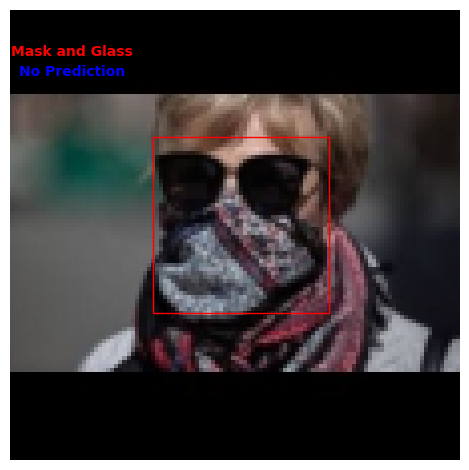

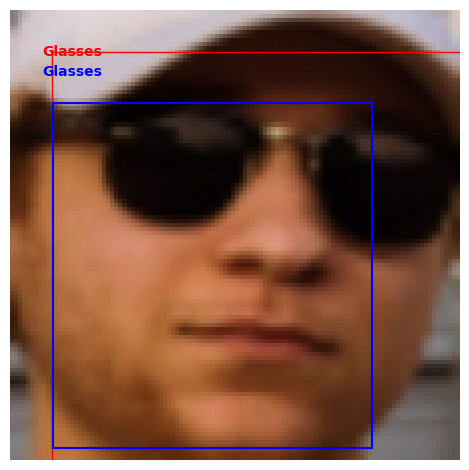

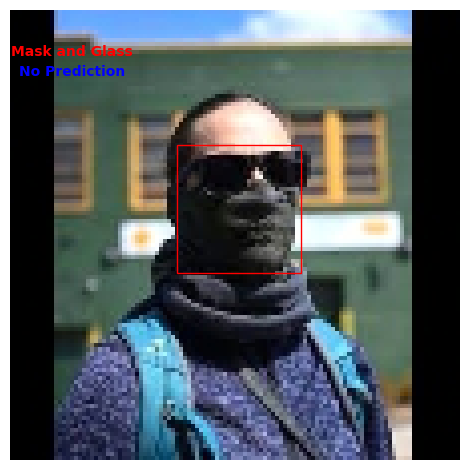

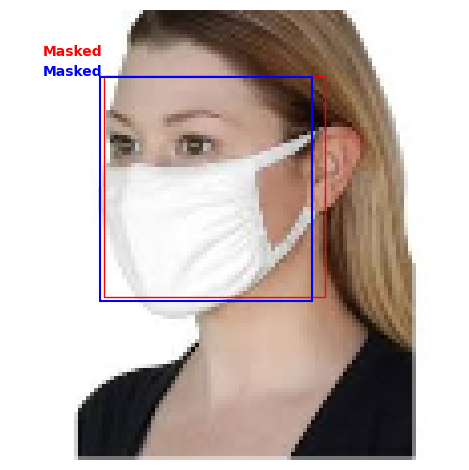

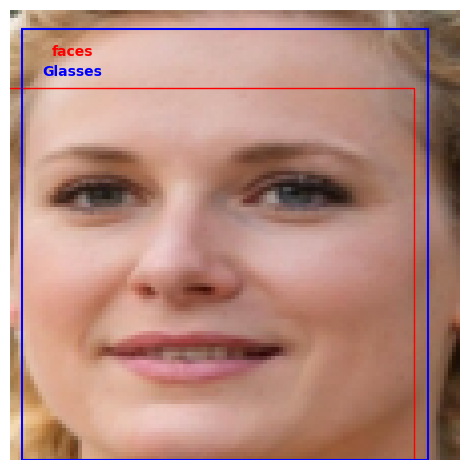

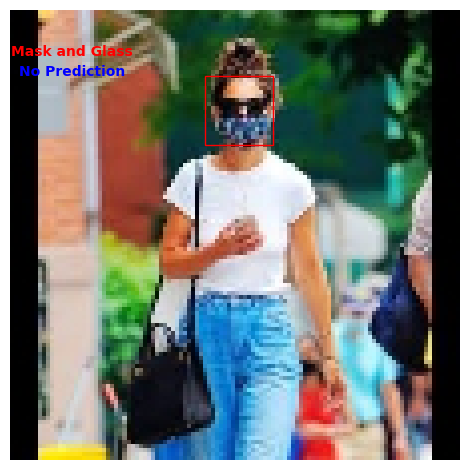

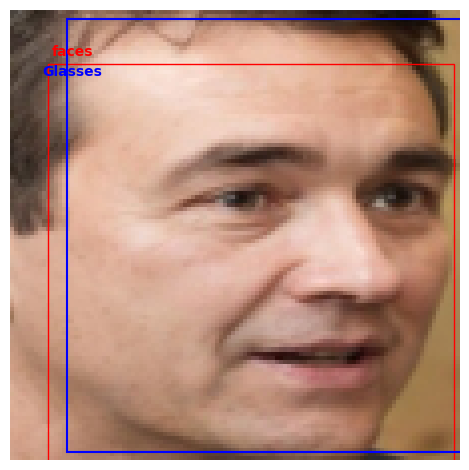

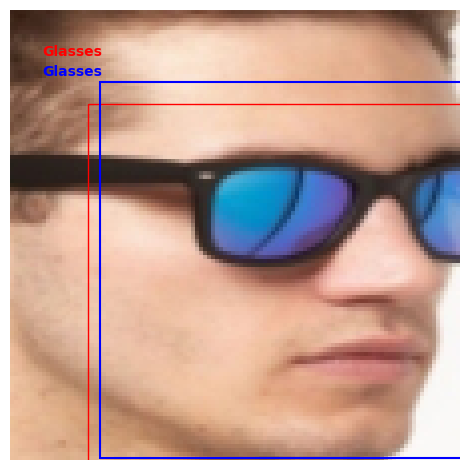

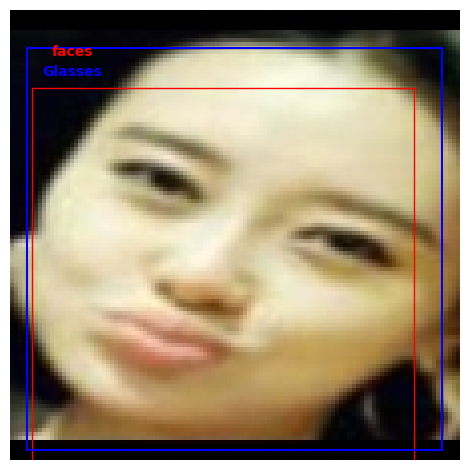

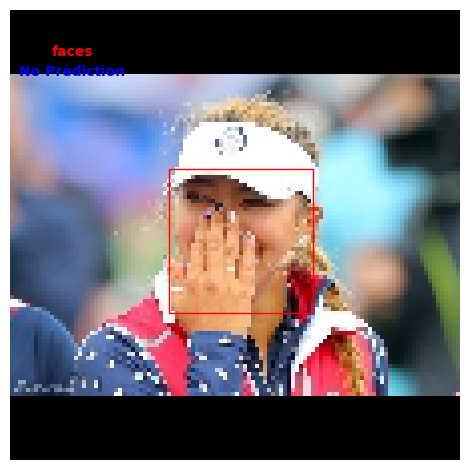

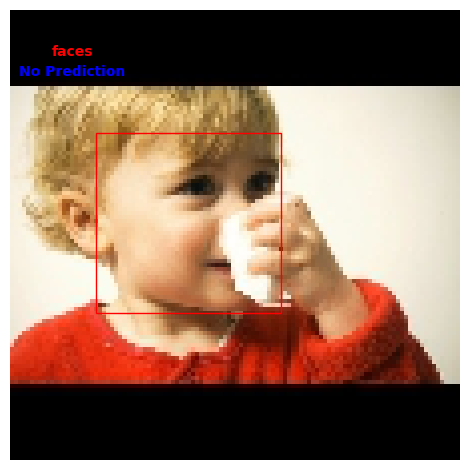

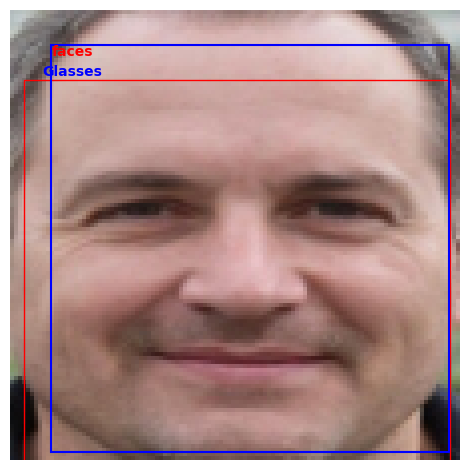

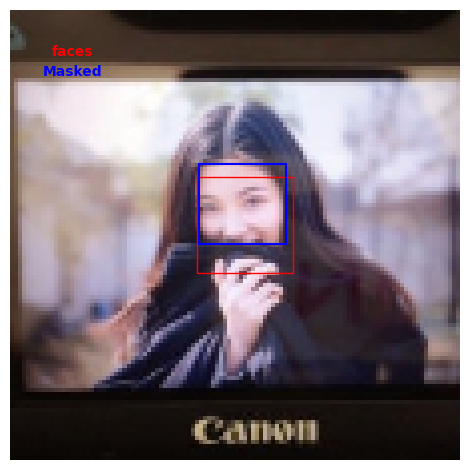

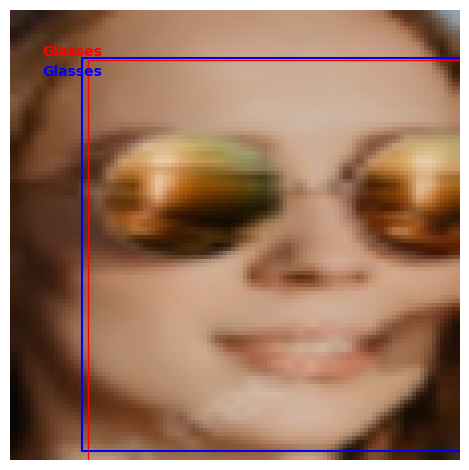

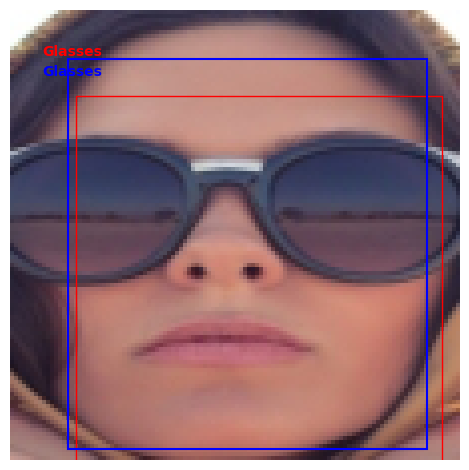

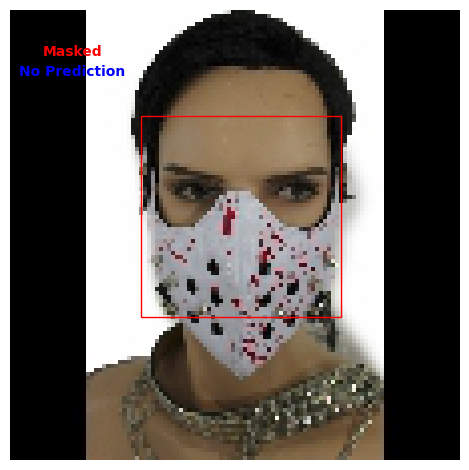

In [37]:
for i in range(len(imgs)):
    plot_image(imgs[i], annotations[i], pred2[i])

In [ ]:
## Checking Inference time
dummy_img = torch.rand((1,3,112,112),dtype=torch.float32, device='cpu')
new_model.to('cpu')
new_model.eval()
import time
start = time.time()
pred = new_model(dummy_img)
end = time.time()
print(f"Inference Time: {round((end-start)*1000, 2)} ms")

Inference Time: 530.62 ms


In [ ]:
print("Predict with loaded model")
plot_image(imgs[3], pred2[3])

Model Accuracy: 0.9 where 6 images have no prediction.


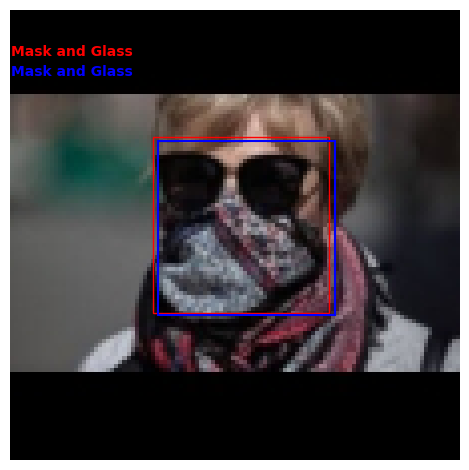

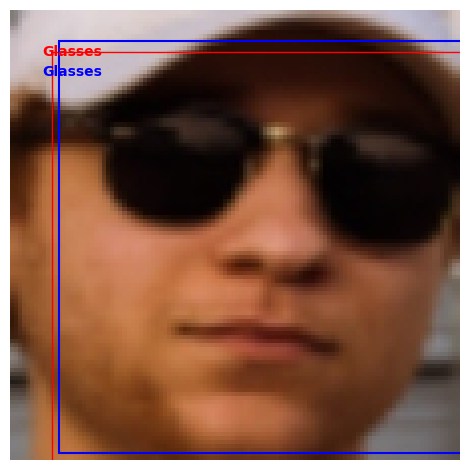

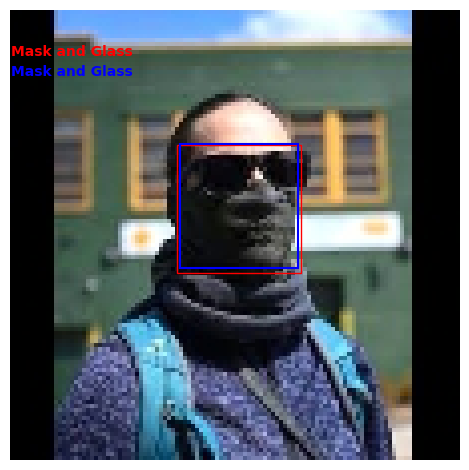

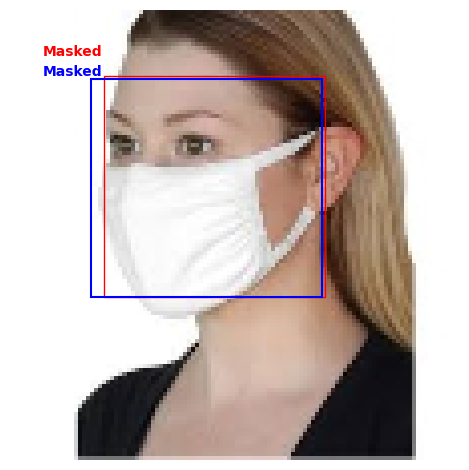

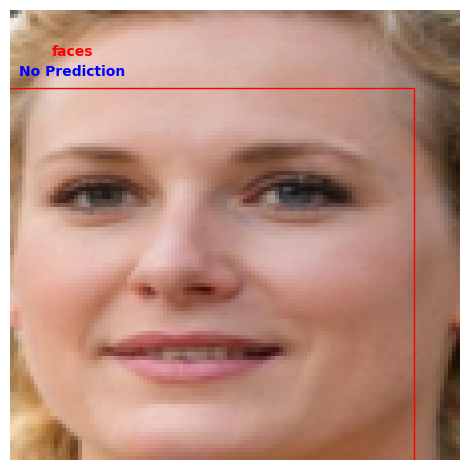

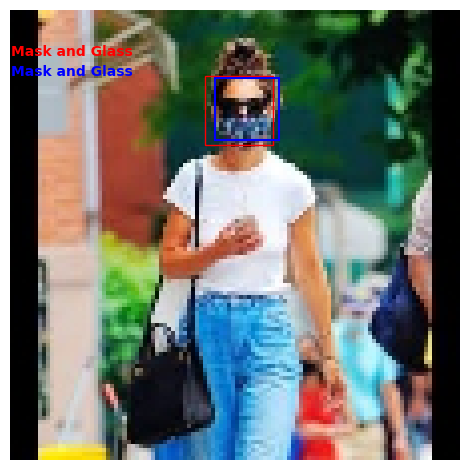

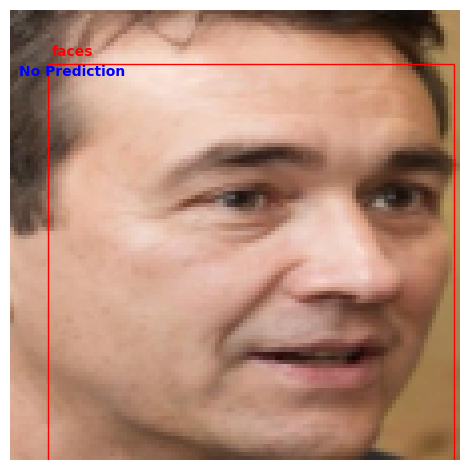

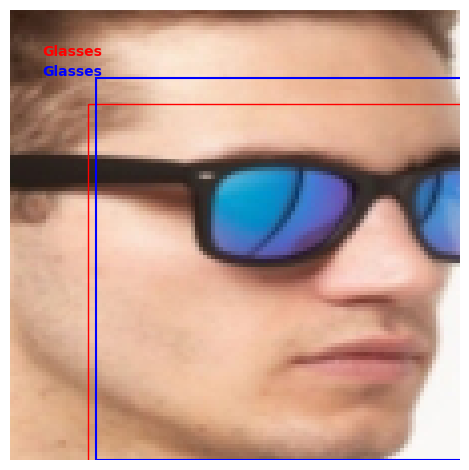

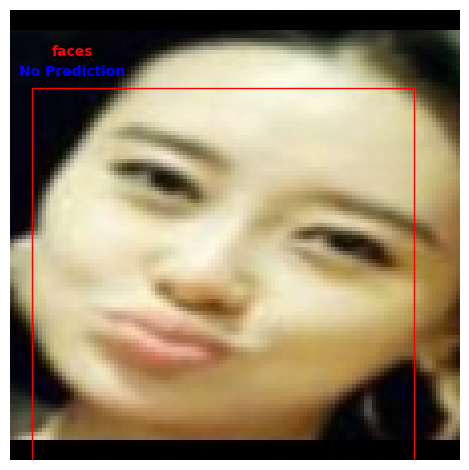

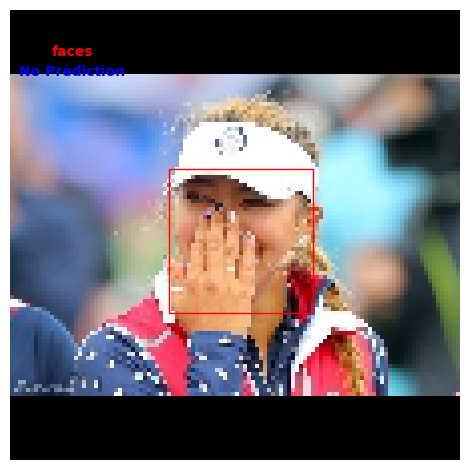

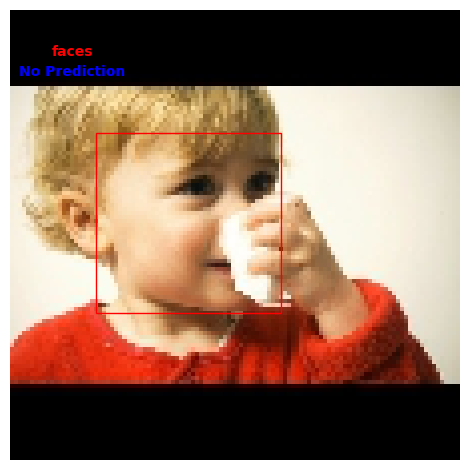

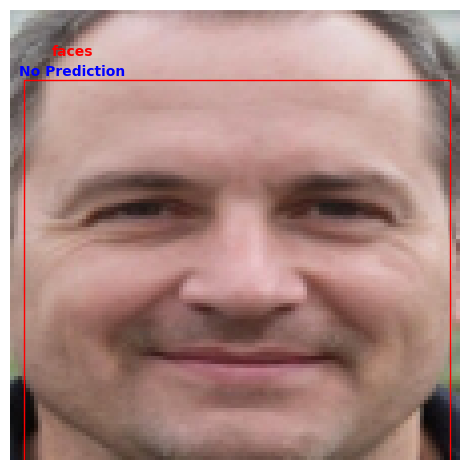

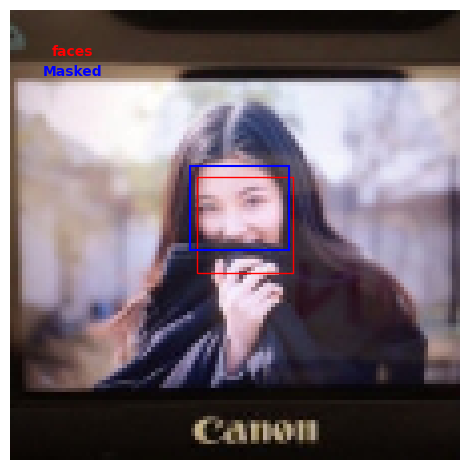

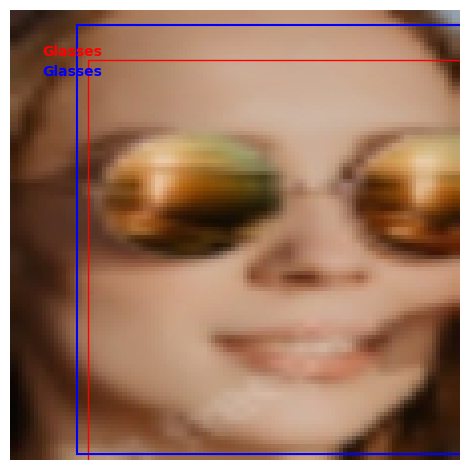

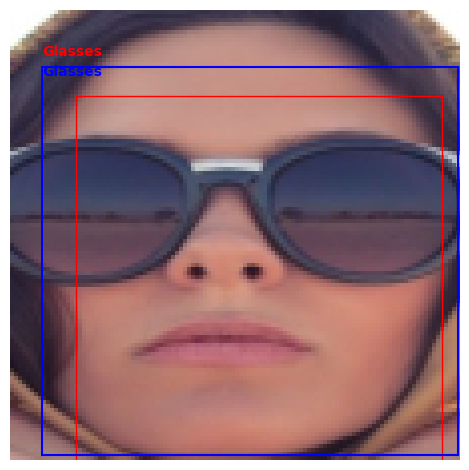

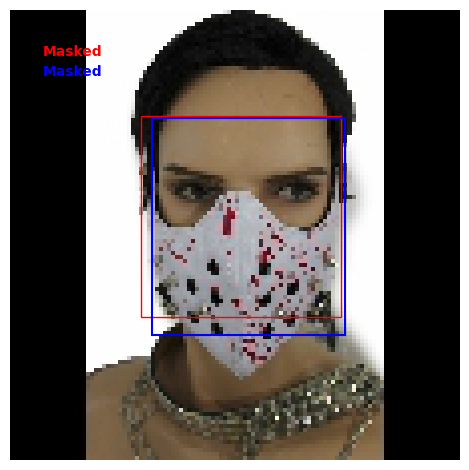

In [40]:
m = get_model_instance_segmentation(4)
m.load_state_dict(torch.load("./frcnn_model_03.pth"))
m.eval()
m = m.to("cpu")
for imgs, annotations in test_loader:
        imgs = list(img.to("cpu") for img in imgs)
        annotations = [{k: v.to("cpu") for k, v in t.items()} for t in annotations]
        break
# imgs = [img.type(torch.qint8) for img in imgs]   
with torch.inference_mode():
        pred_m = m(imgs)
        accuracy(pred_m, annotations)

for i in range(len(imgs)):
    plot_image(imgs[i], annotations[i], pred_m[i])

In [ ]:
from time import time
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import cv2


label_dict = {0:"Faces",
              1:"Masked",
              2:"Glasses",
              3:"Mask&Glass"}
# model = attempt_load("./runs/train/exp3/weights/best.pt")
model = get_model_instance_segmentation(4)
model.load_state_dict(torch.load("./frcnn_model_03.pth"))
model.to("cuda")
model.eval()

cap = cv2.VideoCapture('/home/sp5/Desktop/ML_Assignments/Facefirst/vid02.mp4')
while cap.isOpened():
    start = time()
    ret, frame = cap.read()
    height, width, _ = frame.shape
    frame = cv2.resize(frame, (width//4, height//4))
    original = frame
    frame = frame/255
    frame = np.expand_dims(frame, axis=0).transpose(0,3,1,2)
    # frame = cv2.resize(frame, ())
    # transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
    with torch.inference_mode():
        result = model(torch.tensor(frame, dtype=torch.float).cuda())
    
 
    bbox = result[0]['boxes']
    label = result[0]['labels']
    conf = result[0]['scores']
    for (box, label, conf)in zip(bbox, label, conf):
        # print(box, label, conf)
        xmin, ymin, xmax, ymax = list(box.cpu().numpy())
        # print(int(xmin), int(ymin), int(xmax), int(ymax))
        cv2.rectangle(original, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color=(255,0,255), thickness=1)
        text = f"{label_dict[label.item()]} : {round(conf.item(), 2)}"
        cv2.putText(original, text, (int(xmin), int(ymin)), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,0,255), 1, cv2.LINE_AA)

        cv2.imshow('Screen', original)
        if cv2.waitKey(5) & 0xff==ord('x'):
            break
        if cv2.getWindowProperty("Screen", cv2.WND_PROP_VISIBLE)<1:
            break

        end = time()
        fps = 1/(end-start)
        print(fps)

cap.release()
cv2.destroyAllWindows()

# img = cv2.imread("/home/sp5/Desktop/ML_Assignments/Facefirst/test/MASKED/M002.jpg")
# img = (img/255)
# img = np.expand_dims(img, axis=0).transpose(0,3,1,2)
# print(img.shape)
# result = model(torch.tensor(img, dtype=torch.float))
# # cv2.imshow('Screen', np.squeeze(result.render()))
# # cv2.waitKey(0)
# # cv2.destroyAllWindows()
# print(result)

QObject::moveToThread: Current thread (0x2da779c0) is not the object's thread (0x2dac1380).
Cannot move to target thread (0x2da779c0)

QObject::moveToThread: Current thread (0x2da779c0) is not the object's thread (0x2dac1380).
Cannot move to target thread (0x2da779c0)

QObject::moveToThread: Current thread (0x2da779c0) is not the object's thread (0x2dac1380).
Cannot move to target thread (0x2da779c0)

QObject::moveToThread: Current thread (0x2da779c0) is not the object's thread (0x2dac1380).
Cannot move to target thread (0x2da779c0)

QObject::moveToThread: Current thread (0x2da779c0) is not the object's thread (0x2dac1380).
Cannot move to target thread (0x2da779c0)

QObject::moveToThread: Current thread (0x2da779c0) is not the object's thread (0x2dac1380).
Cannot move to target thread (0x2da779c0)

QObject::moveToThread: Current thread (0x2da779c0) is not the object's thread (0x2dac1380).
Cannot move to target thread (0x2da779c0)

QObject::moveToThread: Current thread (0x2da779c0) is n

0.8084872284082669
9.072747605976245
11.45699839657353
11.996030213847918
12.940909315298414
14.098074343969426
14.142044075202978
14.358449098639571
14.04745780876881
14.074042755950163
14.134609422389971
13.106872328191795
13.10433342706283
13.776116559702032
13.940724639126259
13.291284287380217
14.07905045466599
13.91805732071928
13.036112449299912
13.794330066434256
13.978031353311293
14.027913323545052
13.849809471605656
14.177657442054631
13.138197935754672
10.97181123783614
13.857725766431317
13.861526970844652
11.488599883862344
14.263235214103052
12.33502729154903
14.51085294382209
14.655764742057668
14.812278396971367
14.780333784393324
14.62816327669429
14.846725921835565
14.551681787430395
13.97491095554941
13.909841311953835
13.159013616113446
13.931695132564057
13.635755991625379
13.718891054910838
13.601265986976937
12.316445697338091
12.949099587227199
12.674063867333865
13.089447436913686
13.15765136946981
13.466935514942913
13.385407325378411
11.209441546224237
9.077

AttributeError: 'NoneType' object has no attribute 'shape'

: 